In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from pathlib import Path
from typing import List, Dict, Any
import warnings
warnings.filterwarnings('ignore')

# Set up paths
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)
    

# Import your classes
from data.collection.models import TrainingDataSample, ClassificationResult
from data.collection.config import EventCategory
from ml_classifier import CelebrityMLClassifier, ModelMetrics, TrainingConfig

In [2]:
# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [13]:
models_dir = 'models'
models_dir = Path(models_dir) if models_dir else Path(project_root) / "models"
        
def load_model(model_name):
    """Load all .pkl models from the models directory"""
    print(f"Loading models from: {models_dir}")
    model_path = Path(models_dir, model_name)
    
    if not model_path.exists():
        print(f"Models directory not found: {model_path}")
        return

    try:
        print(f"Loading {model_name}...")
        model_data = joblib.load(model_path)
        
        if 'trained_at' in model_data:
            print(f"   Trained at: {model_data['trained_at']}")
        if 'config' in model_data:
            print(f"   Model type: {model_data['config'].model_type}")
        
        return model_data
    except Exception as e:
        print(f"❌ Failed to load {model_name}: {e}")
    
    
logistic_regression = load_model('celebrity_classifier_logistic_regression.pkl')
naive_bayes = load_model('celebrity_classifier_naive_bayes.pkl')
random_forest = load_model('celebrity_classifier_random_forest.pkl')


Loading models from: models
Loading celebrity_classifier_logistic_regression.pkl...
   Trained at: 2025-06-28 02:34:09.103122
   Model type: logistic_regression
Loading models from: models
Loading celebrity_classifier_naive_bayes.pkl...
   Trained at: 2025-06-28 02:34:09.024826
   Model type: naive_bayes
Loading models from: models
Loading celebrity_classifier_random_forest.pkl...
   Trained at: 2025-06-28 02:34:08.969200
   Model type: random_forest


'logistic_regression'

In [16]:
def create_comparison_dataframe(model_metrics) -> pd.DataFrame:
    """Create a DataFrame comparing all models"""
    comparison_data = []
    
    for model_name, metrics in model_metrics.items():
        row = {
            'Model Name': model_name,
            'Accuracy': metrics.accuracy,
            'Training Samples': metrics.training_samples,
            'Test Samples': metrics.test_samples,
            'CV Mean': np.mean(metrics.cross_val_scores),
            'CV Std': np.std(metrics.cross_val_scores)
        }
        
        # Add per-class F1 scores
        for category in EventCategory:
            if category.value in metrics.f1_score:
                row[f'F1_{category.value}'] = metrics.f1_score[category.value]
        
        comparison_data.append(row)
    
    return pd.DataFrame(comparison_data)

model_matrices = {
    'logistic_regression' : logistic_regression['metrics'],
    'naive_bayes' : naive_bayes['metrics'],
    'random_forest' : random_forest['metrics']
}

matrices = create_comparison_dataframe(model_matrices)
matrices

,Model Name,Accuracy,Training Samples,Test Samples,CV Mean,CV Std,F1_divorce,F1_breakup,F1_engagement,F1_marriage,F1_dating,F1_feud,F1_fight,F1_lawsuit,F1_controversy,F1_new_project,F1_business_venture,F1_social_media_drama,F1_death
0,logistic_regression,0.575758,129,33,0.584279,0.075589,0.800000,0.600000,0.909091,0.222222,0.000000,0.666667,0.0,0.750000,0.000000,0.0,0.0,0.0,NaN
1,naive_bayes,0.484848,129,33,0.504379,0.047606,0.800000,0.444444,0.727273,0.250000,0.000000,0.400000,0.0,0.666667,0.000000,0.0,0.0,0.0,NaN
2,random_forest,0.757576,129,33,0.709791,0.088088,0.888889,0.666667,0.909091,0.500000,0.666667,1.000000,1.0,0.857143,0.666667,1.0,0.0,0.0,0.0


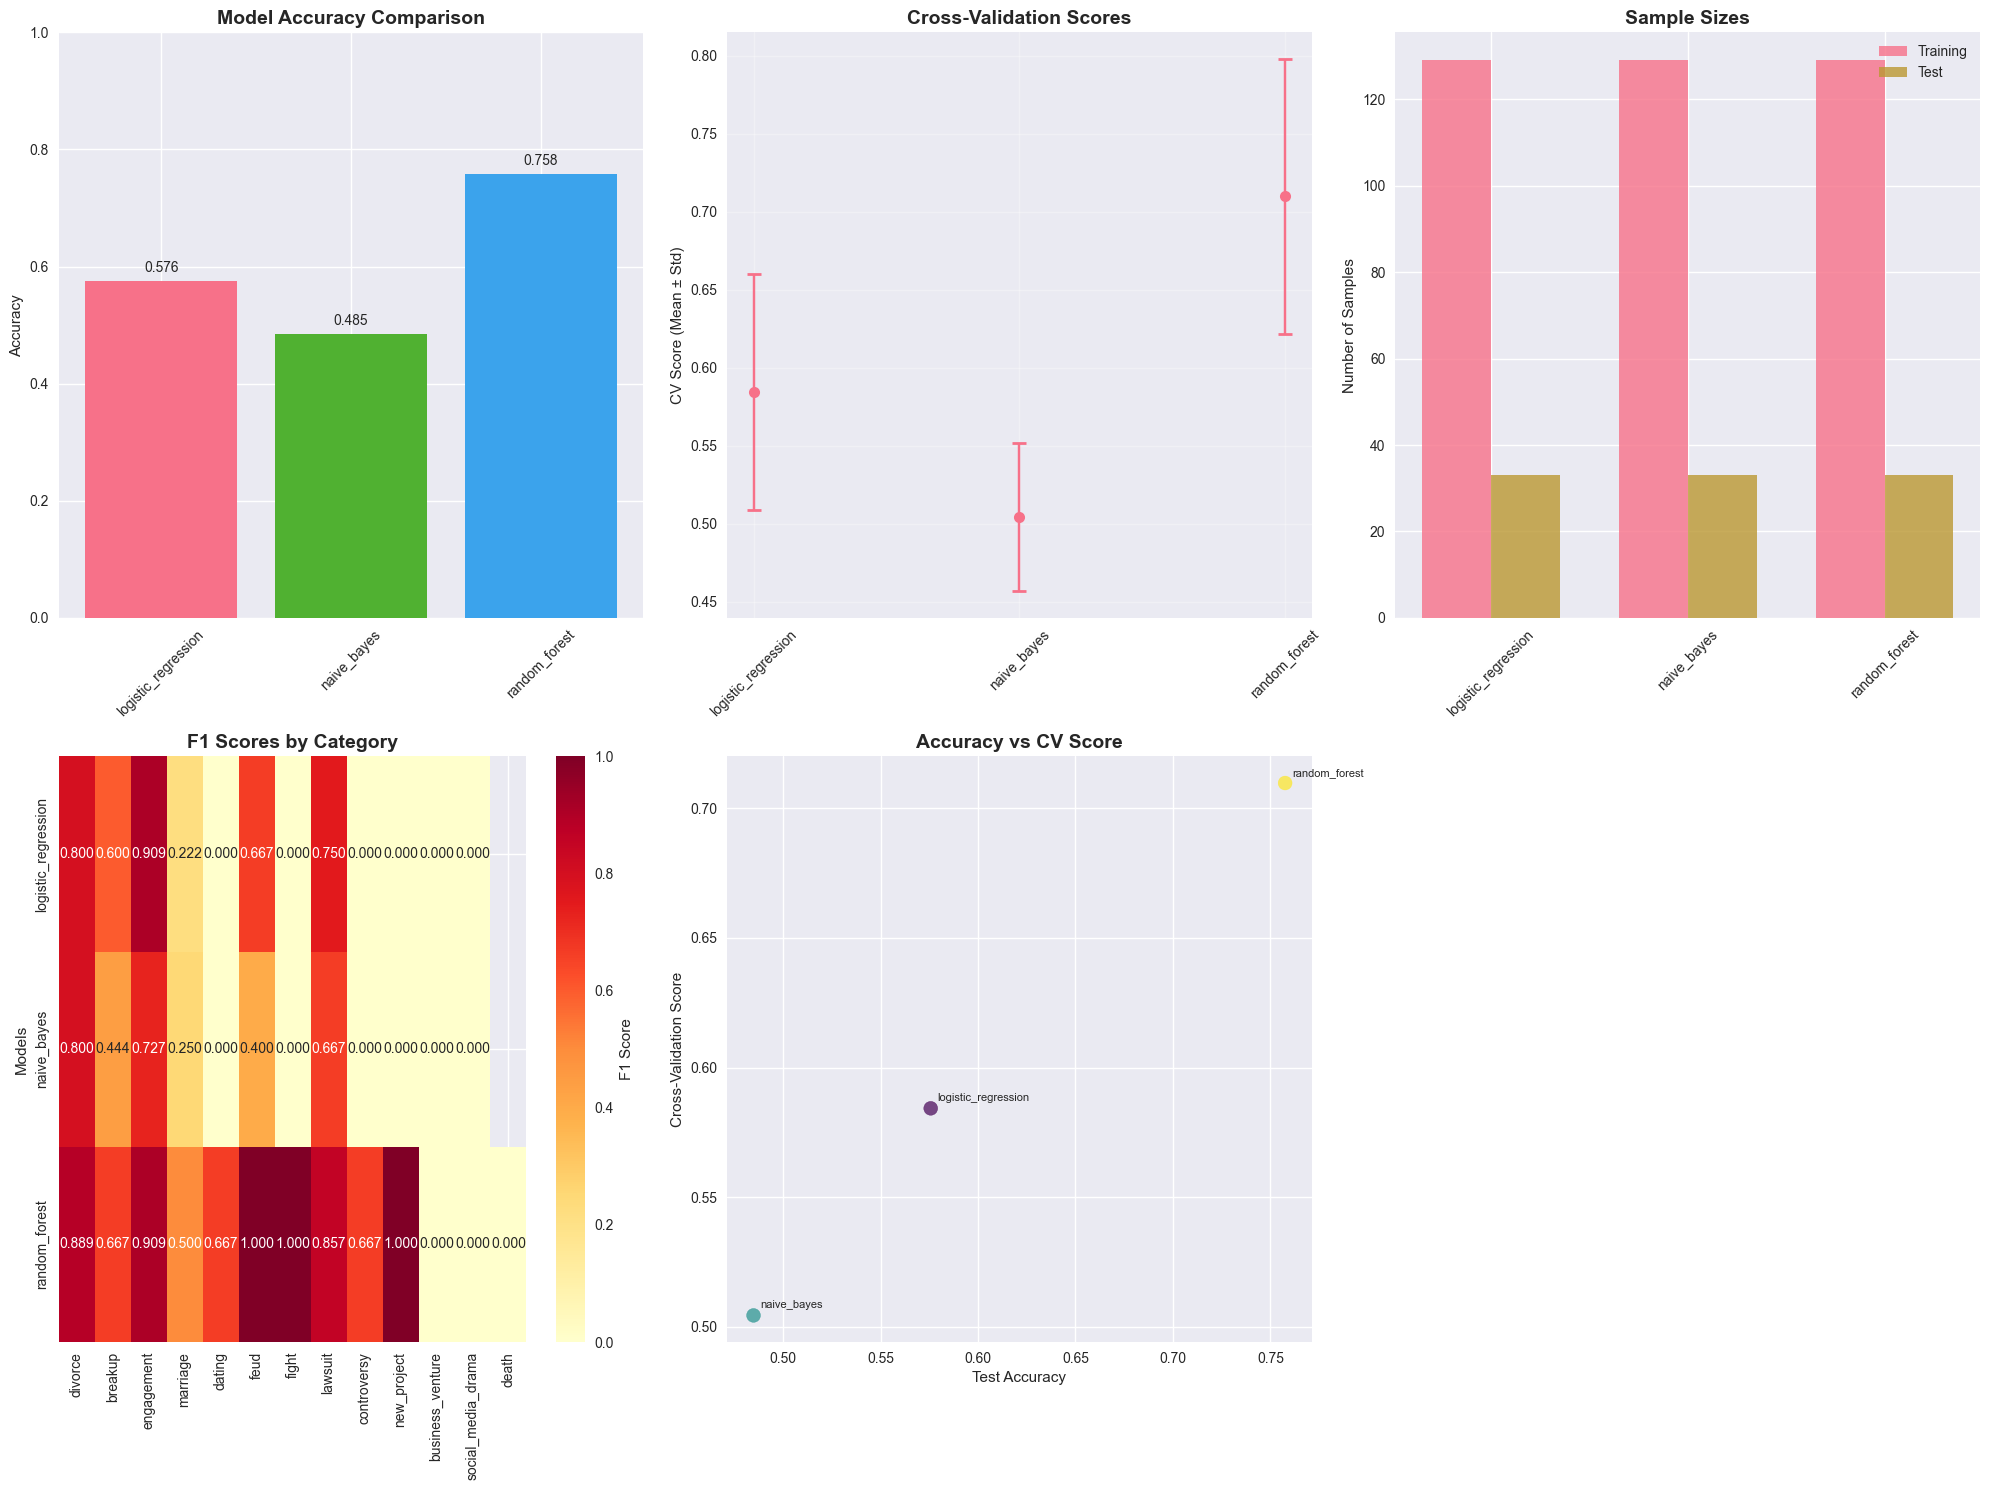

,Model Name,Accuracy,Training Samples,Test Samples,CV Mean,CV Std,F1_divorce,F1_breakup,F1_engagement,F1_marriage,F1_dating,F1_feud,F1_fight,F1_lawsuit,F1_controversy,F1_new_project,F1_business_venture,F1_social_media_drama,F1_death
0,logistic_regression,0.575758,129,33,0.584279,0.075589,0.800000,0.600000,0.909091,0.222222,0.000000,0.666667,0.0,0.750000,0.000000,0.0,0.0,0.0,NaN
1,naive_bayes,0.484848,129,33,0.504379,0.047606,0.800000,0.444444,0.727273,0.250000,0.000000,0.400000,0.0,0.666667,0.000000,0.0,0.0,0.0,NaN
2,random_forest,0.757576,129,33,0.709791,0.088088,0.888889,0.666667,0.909091,0.500000,0.666667,1.000000,1.0,0.857143,0.666667,1.0,0.0,0.0,0.0


In [20]:
def plot_model_comparison(df):
    """Create comprehensive comparison plots"""
    
    # Create a large figure with multiple subplots
    fig = plt.figure(figsize=(20, 15))
    
    # 1. Overall Accuracy Comparison
    plt.subplot(2, 3, 1)
    bars = plt.bar(df['Model Name'], df['Accuracy'], color=sns.color_palette("husl", len(df)))
    plt.title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
    plt.ylabel('Accuracy')
    plt.xticks(rotation=45)
    plt.ylim(0, 1)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom')
    
    # 2. Cross-Validation Scores with Error Bars
    plt.subplot(2, 3, 2)
    plt.errorbar(df['Model Name'], df['CV Mean'], yerr=df['CV Std'], 
                fmt='o', capsize=5, capthick=2, markersize=8)
    plt.title('Cross-Validation Scores', fontsize=14, fontweight='bold')
    plt.ylabel('CV Score (Mean ± Std)')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    # 3. Training vs Test Sample Sizes
    plt.subplot(2, 3, 3)
    x = np.arange(len(df))
    width = 0.35
    plt.bar(x - width/2, df['Training Samples'], width, label='Training', alpha=0.8)
    plt.bar(x + width/2, df['Test Samples'], width, label='Test', alpha=0.8)
    plt.title('Sample Sizes', fontsize=14, fontweight='bold')
    plt.ylabel('Number of Samples')
    plt.xticks(x, df['Model Name'], rotation=45)
    plt.legend()
    
    # 4. Per-Category F1 Scores Heatmap
    plt.subplot(2, 3, 4)
    f1_columns = [col for col in df.columns if col.startswith('F1_')]
    if f1_columns:
        f1_data = df[['Model Name'] + f1_columns].set_index('Model Name')
        f1_data.columns = [col.replace('F1_', '') for col in f1_data.columns]
        sns.heatmap(f1_data, annot=True, cmap='YlOrRd', fmt='.3f', cbar_kws={'label': 'F1 Score'})
        plt.title('F1 Scores by Category', fontsize=14, fontweight='bold')
        plt.ylabel('Models')

    # 5. Accuracy vs CV Score Scatter
    plt.subplot(2, 3, 5)
    scatter = plt.scatter(df['Accuracy'], df['CV Mean'], 
                        s=100, alpha=0.7, c=range(len(df)), cmap='viridis')
    plt.xlabel('Test Accuracy')
    plt.ylabel('Cross-Validation Score')
    plt.title('Accuracy vs CV Score', fontsize=14, fontweight='bold')
    
    # Add model names as annotations
    for i, model_name in enumerate(df['Model Name']):
        plt.annotate(model_name, (df['Accuracy'].iloc[i], df['CV Mean'].iloc[i]),
                    xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    return df

df = plot_model_comparison(matrices)
df